In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_blowup_max_slope(dists: List[float], min_slope_threshold: float = 0.02):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_blowup_point(kl_divergences, window_length=11, polyorder=3, threshold=2):
    """
    Find the blowup point using the 2nd derivative of KL divergences.

    Args:
    kl_divergences (array-like): KL divergence values at each step.
    window_length (int): The length of the Savitzky-Golay filter window.
    polyorder (int): The order of the polynomial used to fit the samples.
    threshold (float): The threshold for identifying a significant change in the 2nd derivative.

    Returns:
    int: The index of the detected blowup point.
    """
    # Smooth the KL divergences using Savitzky-Golay filter
    smoothed = savgol_filter(kl_divergences, window_length, polyorder)

    # Compute 1st and 2nd derivatives
    first_derivative = np.gradient(smoothed)
    second_derivative = np.gradient(first_derivative)

    # Normalize the 2nd derivative
    normalized_second_derivative = (
        second_derivative - np.mean(second_derivative)
    ) / np.std(second_derivative)

    # Find points where the normalized 2nd derivative exceeds the threshold
    potential_blowups = np.where(normalized_second_derivative > threshold)[0]

    if len(potential_blowups) > 0:
        # Return the first point that exceeds the threshold
        return potential_blowups[0]
    else:
        # If no point exceeds the threshold, return the point of maximum 2nd derivative
        return np.argmax(second_derivative)


def euclidean_distance_tensor_vector(tensor, vector):
    """
    Compute the Euclidean distance between each slice of a tensor and a vector.

    Args:
    tensor (torch.Tensor or np.ndarray): A tensor of shape (N, D) where N is the number of slices
                                         and D is the dimensionality of each slice.
    vector (torch.Tensor or np.ndarray): A vector of shape (D,)

    Returns:
    torch.Tensor or np.ndarray: A 1D array of Euclidean distances for each slice of the tensor
    """
    if isinstance(tensor, np.ndarray) and isinstance(vector, np.ndarray):
        return np.sqrt(np.sum((tensor - vector) ** 2, axis=1))
    elif isinstance(tensor, torch.Tensor) and isinstance(vector, torch.Tensor):
        return torch.sqrt(torch.sum((tensor - vector.unsqueeze(0)) ** 2, dim=1))
    else:
        raise TypeError("Both inputs must be either numpy arrays or PyTorch tensors")

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [5]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


In [6]:
metadata, activations = [], []

n_files = 10

for path in sorted(glob("observations/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [8]:
activations.shape

(10000, 100, 768)

In [9]:
resid_stream_mean = torch.tensor(activations[:, 0, :]).mean(dim=0).numpy()

tensor(99)


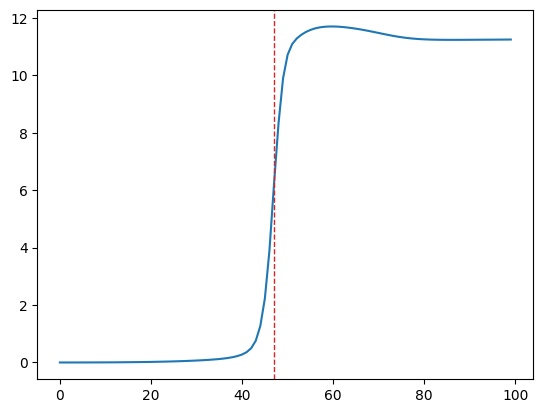

In [16]:
idx = 0

m = metadata[idx]
steps = m["steps_metadata"]
kl_div = [s["kl_div"] for s in steps]
sims = F.cosine_similarity(
    torch.tensor(activations[idx]), torch.tensor(resid_stream_mean)
)

# sims = euclidean_distance_tensor_vector(activations[idx], resid_stream_mean)

max_cosine_sim = sims.argmin()
print(max_cosine_sim)
bp = find_blowup_max_slope(kl_div)
# bp = find_blowup_point(kl_div)

plt.plot(kl_div)
plt.axvline(x=bp, color="tab:red", linestyle="--", linewidth=1, label="blowup")
# plt.axvline(x=max_cosine_sim, color="tab:green", linestyle="--", linewidth=1, label="max_cosine_sim")
plt.show()

# plt.plot(sims)
# plt.axvline(x=bp, color="tab:red", linestyle="--", linewidth=1, label="blowup")
# plt.axvline(x=max_cosine_sim, color="tab:green", linestyle="--", linewidth=1, label="max_cosine_sim")
# plt.show()

In [17]:
bps = []
sims_to_resid_mean = []

for idx, m in enumerate(metadata):
    m = metadata[idx]
    steps = m["steps_metadata"]
    dists = [s["kl_div"] for s in steps]
    sims = F.cosine_similarity(
        torch.tensor(activations[idx]), torch.tensor(resid_stream_mean)
    )
    cosine_sim = sims.argmax()

    # sims = euclidean_distance_tensor_vector(activations[idx], resid_stream_mean)
    # cosine_sim = sims.argmin()

    # bp = find_blowup_point(dists)
    bp = find_blowup_max_slope(dists)

    bps.append(bp)
    sims_to_resid_mean.append(cosine_sim)

In [18]:
stats.pearsonr(bps, sims_to_resid_mean)

PearsonRResult(statistic=-0.3459624472929399, pvalue=3.945744156515004e-279)

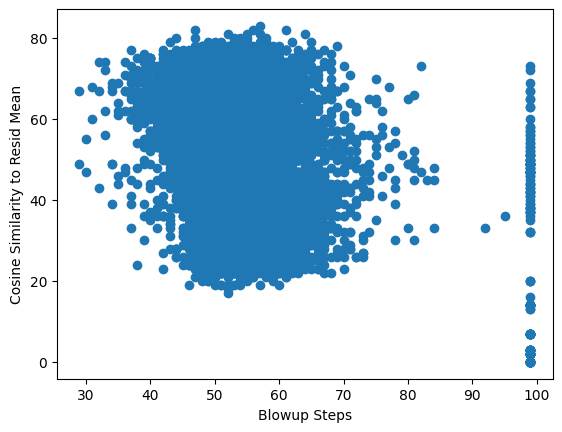

In [14]:
plt.scatter(bps, sims_to_resid_mean)
plt.xlabel("Blowup Steps")
plt.ylabel("Cosine Similarity to Resid Mean")
plt.show()